In [1]:
import os, sys

module_path = os.path.abspath(os.path.join("../.."))
sys.path.append(module_path)

## Load datasets

In [2]:
from SLTDataset import SLTDataset


DATASETS = ["LSAT", "RWTH_PHOENIX_2014T", "GSL", "ISL"]
DATA_DIR = "/mnt/disk3Tb/slt-datasets/"
INPUT_MODE = "pose"
OUTPUT_MODE = "text"


datasets: dict[str, SLTDataset] = {}
for dataset in DATASETS:
    datasets[dataset] = SLTDataset(
        data_dir=DATA_DIR + dataset,
        input_mode=INPUT_MODE,
        output_mode=OUTPUT_MODE,
    )

Loaded metadata for dataset: LSA-T
Loaded  annotations at /mnt/disk3Tb/slt-datasets/LSAT/annotations.csv


Validating files: 100%|██████████| 8459/8459 [00:00<00:00, 13615.22it/s]


Missing 9 files out of 8459 (0.11%)

Loaded metadata for dataset: RWTH-PHOENIX-Weather 2014 T: Parallel Corpus of Sign Language Video, Gloss and Translation
Loaded  annotations at /mnt/disk3Tb/slt-datasets/RWTH_PHOENIX_2014T/annotations.csv


Validating files: 100%|██████████| 8257/8257 [00:00<00:00, 28695.95it/s]


Dataset loaded correctly

Loaded metadata for dataset: The Greek Sign Language (GSL) Dataset
Loaded  annotations at /mnt/disk3Tb/slt-datasets/GSL/annotations.csv


Validating files: 100%|██████████| 10290/10290 [00:00<00:00, 26519.36it/s]


Dataset loaded correctly

Loaded metadata for dataset: ISLTranslate
Loaded  annotations at /mnt/disk3Tb/slt-datasets/ISL/annotations.csv


Validating files: 100%|██████████| 125856/125856 [00:00<00:00, 274377.44it/s]

Missing 17534 files out of 125856 (13.93%)



In [3]:
import pandas as pd
from tqdm import tqdm
from WordLevelTokenizer import WordLevelTokenizer


def get_tokenizer(dataset: SLTDataset) -> WordLevelTokenizer:
    tokenizer = WordLevelTokenizer()
    tokenizer.fit(dataset.annotations["text"].tolist())
    return tokenizer


samples: list[tuple[str, str, float, list[int]]] = []
tokenizers = {name: get_tokenizer(dataset) for name, dataset in datasets.items()}

for name, dataset in datasets.items():
    for i in tqdm(range(len(dataset)), desc=f"Processing {name}", unit="sample"):
        pose, text = dataset.get_item_raw(i)
        token_ids = tokenizers[name].encode(text)
        samples.append((name, text, len(pose), token_ids))

df = pd.DataFrame(samples, columns=["dataset", "text", "pose_length", "token_ids"])
df["token_length"] = df["token_ids"].apply(len)

Processing dataset LSAT
Processing dataset RWTH_PHOENIX_2014T
Processing dataset GSL
Processing dataset ISL


In [4]:
df.head()

,dataset,text,pose_length,token_ids,token_length
0,LSAT,"para dejar en el camino tanto inglés, para que...",340,"[2, 4, 5, 6, 7, 8, 9, 10, 4, 11, 7, 12, 13, 14...",22
1,LSAT,mientras trabajábamos para brindarte toda la ...,676,"[2, 22, 23, 4, 24, 25, 26, 27, 6, 28, 29, 30, ...",45
2,LSAT,será recordado por siempre. este programa es u...,208,"[2, 51, 52, 18, 53, 54, 55, 56, 14, 57, 43, 58...",14
3,LSAT,buenas noches. bienvenidos a cn sordos argent...,196,"[2, 60, 61, 62, 43, 63, 64, 65, 7, 29, 66, 34,...",18
4,LSAT,mi nombre es lucía.,78,"[2, 70, 71, 56, 72, 3]",6


In [ ]:
df.groupby("dataset").describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

dataset                      GSL            ISL         LSAT  \
pose_length  count  10290.000000  108322.000000  8450.000000   
             mean     100.665598     215.521888   287.716095   
             std       78.071866     129.001008   218.443853   
             min        6.000000      11.000000    30.000000   
             10%       17.000000      86.000000    90.000000   
             25%       40.000000     124.000000   137.000000   
             50%       89.000000     189.000000   222.000000   
             75%      136.000000     274.000000   372.000000   
             90%      193.000000     373.000000   569.100000   
             95%      254.000000     444.000000   725.550000   
             99%      349.110000     635.000000  1050.510000   
             max      615.000000    2370.000000  2695.000000   
token_length count  10290.000000  108322.000000  8450.000000   
             mean       6.183090      12.623585    18.050178   
             std        2.614193       5.361420    11.164755   
             min        3.000000       2.000000     3.000000   
             10%        3.000000       6.000000     7.000000   
             25%        4.000000       9.000000    10.000000   
             50%        6.000000      12.000000    15.000000   
             75%        8.000000      16.000000    23.000000   
             90%        9.000000      20.000000    33.000000   
             95%       11.000000      22.000000    40.000000   
             99%       13.000000      26.000000    54.000000   
             max       20.000000      68.000000   155.000000   

dataset             RWTH_PHOENIX_2014T  
pose_length  count         8257.000000  
             mean           114.782124  
             std             49.163683  
             min             16.000000  
             10%             53.000000  
             25%             81.000000  
             50%            110.000000  
             75%            142.000000  
             90%            180.000000  
             95%            205.000000  
             99%            252.440000  
             max            475.000000  
token_length count         8257.000000  
             mean            15.772193  
             std              5.884903  
             min              3.000000  
             10%              9.000000  
             25%             12.000000  
             50%             15.000000  
             75%             19.000000  
             90%             24.000000  
             95%             27.000000  
             99%             32.440000  
             max             54.000000

In [6]:
print(f"Hours of video: {df.groupby('dataset')['pose_length'].sum() / 30 / 60 / 60}")

Hours of video: dataset
GSL                     9.591194
ISL                   216.164463
LSAT                   22.511120
RWTH_PHOENIX_2014T      8.775519
Name: pose_length, dtype: float64


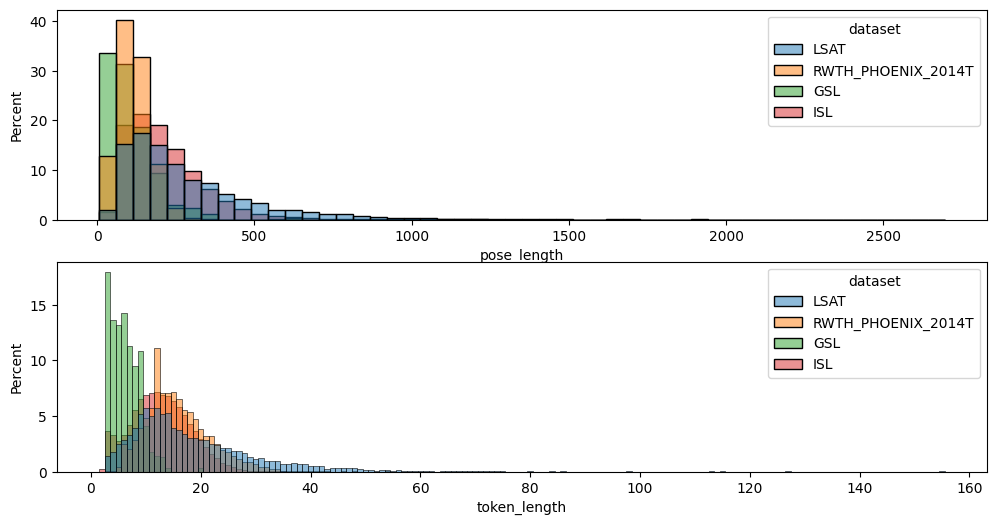

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axs = plt.subplots(2, 1, figsize=(12, 6))
sns.histplot(
    data=df,
    x="pose_length",
    hue="dataset",
    bins=50,
    ax=axs[0],
    stat="percent",
    common_norm=False,
)
sns.histplot(
    data=df,
    x="token_length",
    hue="dataset",
    bins=50,
    ax=axs[1],
    discrete=True,
    stat="percent",
    common_norm=False,
)
plt.show()

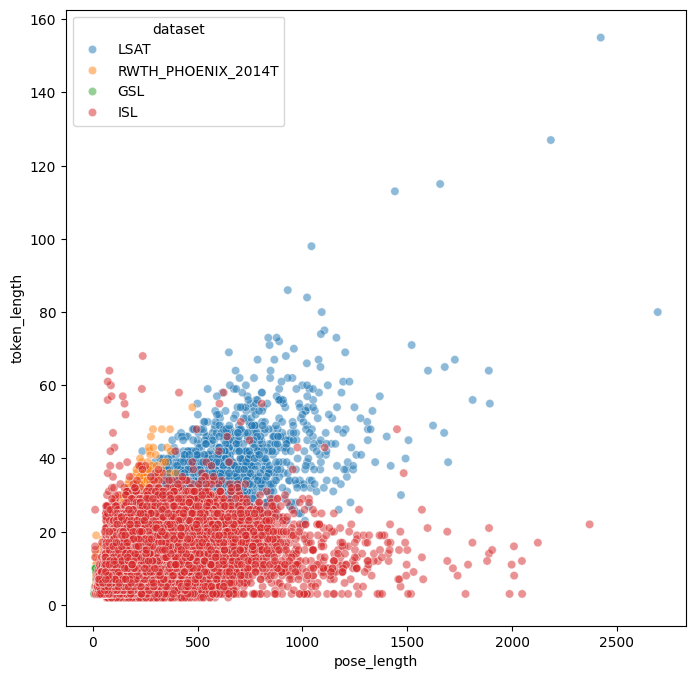

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(
    data=df, x="pose_length", y="token_length", hue="dataset", alpha=0.5, ax=ax
)
plt.show()

## Word frequency analysis

Percentage of different sentences over the whole dataset

In [9]:
print(f"Unique sentences per dataset: \n{df.groupby('dataset')['text'].nunique()}")
print(
    f"Unique sentences percentage per dataset: \n{100 * df.groupby('dataset')['text'].nunique() / df.groupby('dataset')['text'].count()}"
)

Unique sentences per dataset: 
dataset
GSL                      327
ISL                   104737
LSAT                    8016
RWTH_PHOENIX_2014T      7956
Name: text, dtype: int64
Unique sentences percentage per dataset: 
dataset
GSL                    3.177843
ISL                   96.690423
LSAT                  94.863905
RWTH_PHOENIX_2014T    96.354608
Name: text, dtype: float64


In [10]:
full_texts = df.groupby("dataset").agg({"token_ids": "sum"})
full_texts["token_ids"] = full_texts["token_ids"].apply(
    lambda tokens: list(filter(lambda token: token != 2 and token != 3, tokens))
)
print(f"Vocab size per dataset: \n{full_texts['token_ids'].apply(set).apply(len)}")

Vocab size per dataset: 
dataset
GSL                     479
ISL                   70375
LSAT                  20472
RWTH_PHOENIX_2014T     3000
Name: token_ids, dtype: int64


In [17]:
full_texts_dfs = {
    dataset: pd.DataFrame(
        {"token": full_texts.loc[dataset, "token_ids"]},
    )
    for dataset in DATASETS
}
token_freqs = {}
for dataset in DATASETS:
    frequency_counts = (
        full_texts_dfs[dataset].value_counts().value_counts().sort_index()
    )
    token_freqs[dataset] = 100 * frequency_counts / frequency_counts.sum()

token_freqs_df = pd.DataFrame(token_freqs)
print("Token frequency distribution per dataset:")
token_freqs_df.head()

Token frequency distribution per dataset:


,LSAT,RWTH_PHOENIX_2014T,GSL,ISL
count,,,,
1,58.616647,37.000000,4.592902,50.208171
2,15.127980,11.833333,0.417537,14.382948
3,7.258695,7.166667,0.417537,7.143162
4,4.288785,4.066667,0.417537,4.554174
5,2.676827,3.466667,0.208768,3.160213


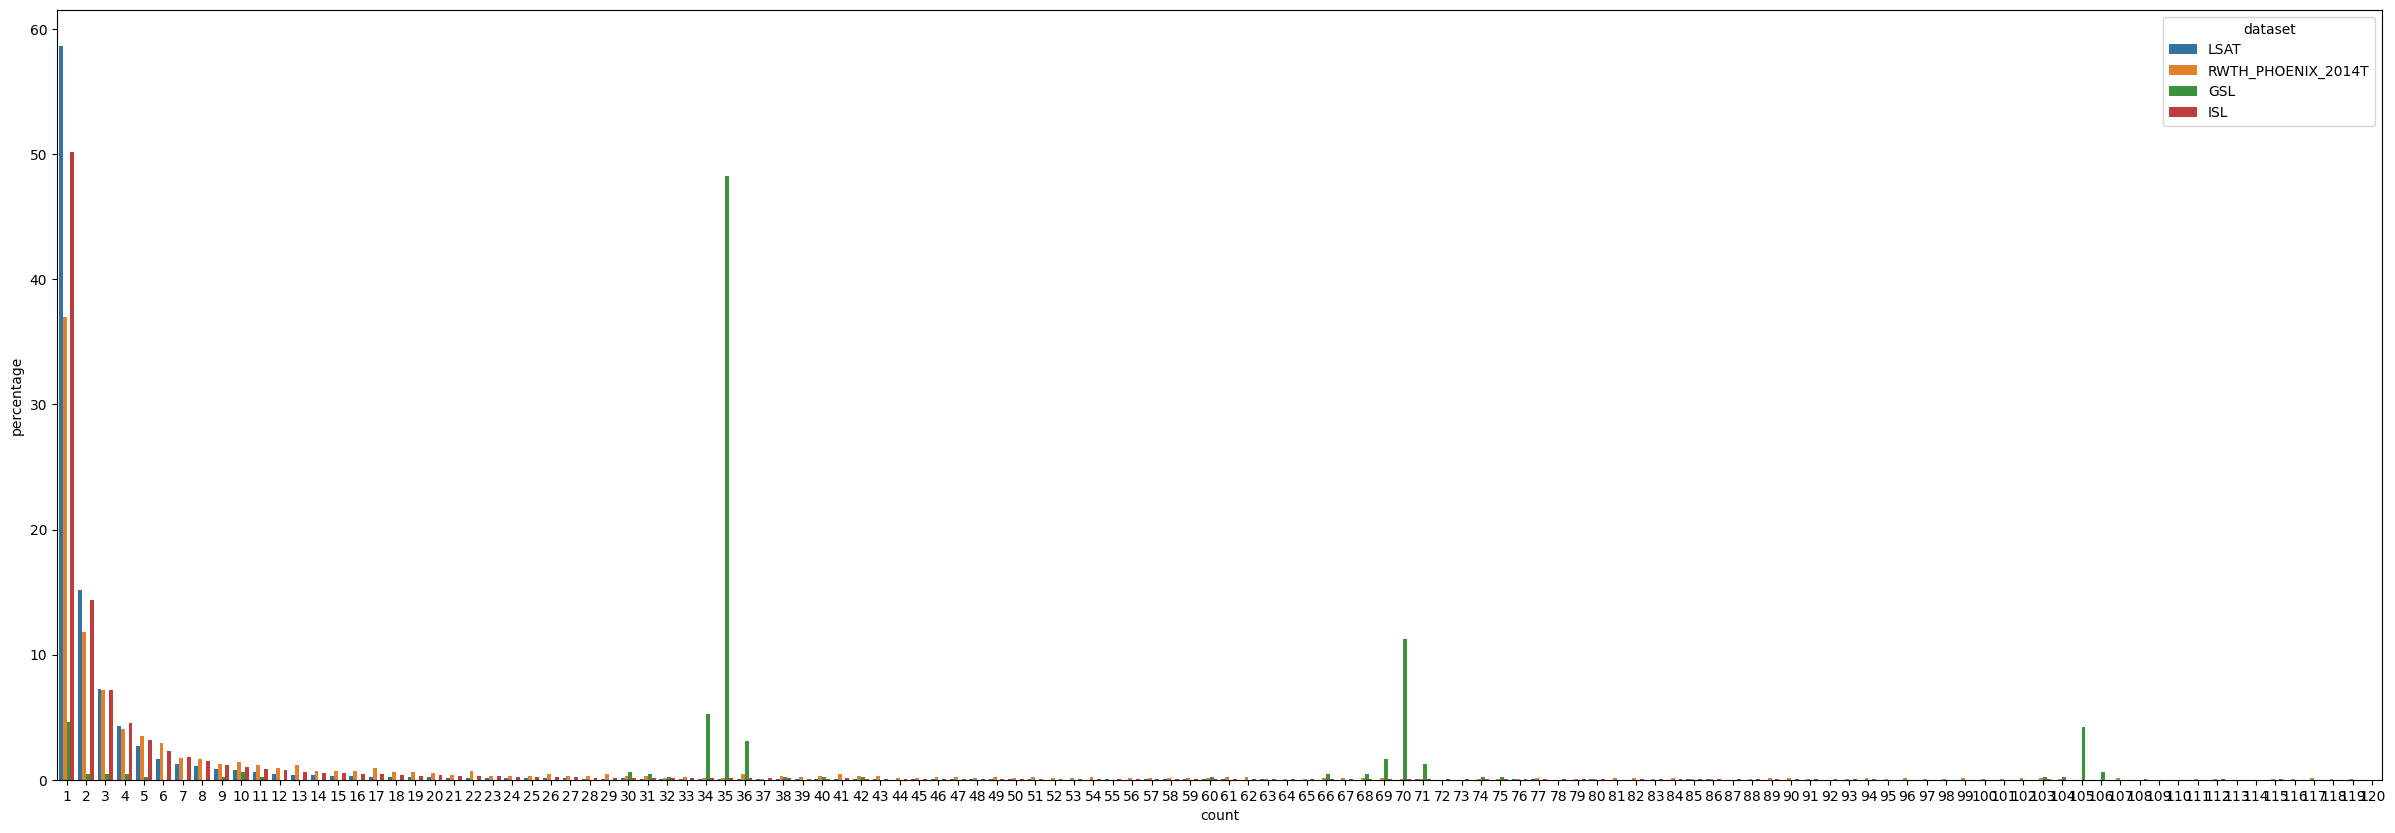

In [12]:
TO_PLOT = 120
token_freqs_top = (
    token_freqs_df[:TO_PLOT].reset_index().rename(columns={"index": "count"})
)
token_freqs_top_melted = token_freqs_top.melt(
    id_vars="count", var_name="dataset", value_name="percentage"
)

plt.figure(figsize=(30, 10))
sns.barplot(x="count", y="percentage", hue="dataset", data=token_freqs_top_melted)
plt.show()